# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            z = torch.randn(8*n_classes, z_dim).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
batch_size = 128

data_dir = 'data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
 
where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instead maximize a lower bound to the log-likelihood:
 
Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$.

The variational posterior $q_{\phi}(z|x)$ is also called the encoder and the generative model $p_{\theta}(x|z)$, the decoder or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), I)$ the term $\log p_\theta(x|z)$ reduces to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0, I)$.

Variational Autoencoders were introduced by Kingma and Welling (2013), see also (Doersch, 2016) for a tutorial.

There are various examples of VAE in PyTorch available here or here. The code below is taken from this last source.

In [4]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take Binary Cross-Entropy. The code below is still from the PyTorch tutorial (with minor modifications to avoid warnings!).

In [5]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Epoch[1/15], Step [10/469], Reconst Loss: 279.6448, KL Div: 30.6569
Epoch[1/15], Step [20/469], Reconst Loss: 235.9438, KL Div: 7.8844
Epoch[1/15], Step [30/469], Reconst Loss: 214.3078, KL Div: 9.8878
Epoch[1/15], Step [40/469], Reconst Loss: 203.4617, KL Div: 5.2650
Epoch[1/15], Step [50/469], Reconst Loss: 210.9200, KL Div: 5.8899
Epoch[1/15], Step [60/469], Reconst Loss: 202.5065, KL Div: 7.6929
Epoch[1/15], Step [70/469], Reconst Loss: 186.5334, KL Div: 7.6344
Epoch[1/15], Step [80/469], Reconst Loss: 196.1834, KL Div: 7.0995
Epoch[1/15], Step [90/469], Reconst Loss: 191.7822, KL Div: 9.8381
Epoch[1/15], Step [100/469], Reconst Loss: 183.2844, KL Div: 9.9311
Epoch[1/15], Step [110/469], Reconst Loss: 169.4161, KL Div: 10.5780
Epoch[1/15], Step [120/469], Reconst Loss: 155.9755, KL Div: 12.9000
Epoch[1/15], Step [130/469], Reconst Loss: 158.4694, KL Div: 13.1078
Epoch[1/15], Step [140/469], Reconst Loss: 147.5194, KL Div: 13.9958
Epoch[1/15], Step [150/469], Reconst Loss: 141.3657,

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

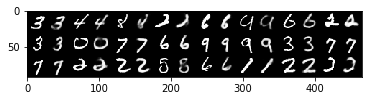

In [6]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

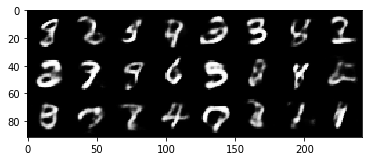

In [7]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this notebook, we explore ways to generates zeroes, ones, twos and so on. As a by-product, we show how our VAE will allow us to do clustering.

The main idea is to build what we call a Gumbel VAE as described below.

# Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|,c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NeurIPS paper: (Dupont, 2018). Make minimal modifications to previous architecture.

The idea is to incorporate a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planned, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation, we need to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in (Jang et al., 2016). This is implemented in PyTorch thanks to F.gumbel_softmax.

In [38]:
n_classes = 10

class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        # encoder layers
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(h_dim, n_classes)
        self.fc5 = nn.Linear(z_dim+n_classes, h_dim)
        self.fc6 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h2 = self.fc2(h)
        h3 = self.fc3(h)
        h4 = F.log_softmax(self.fc4(h))
        return h2, h3, h4 
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        z = torch.cat([z, y_onehot], 1)
        h = F.relu(self.fc5(z))
        return torch.sigmoid(self.fc6(h))
        
    
    def forward(self, x):
        mu, log_var, q = self.encode(x)
        z = self.reparameterize(mu, log_var)
        q = F.gumbel_softmax(q)
        x_reconst = self.decode(z, q)
        return x_reconst, mu, log_var, q
        

model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in (Dupont, 2018)

In [46]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            
            x_reconst, mu, log_var, q = model(x)
            _, _, q_encoded = model.encode(x)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            H_cat = - F.cross_entropy(q_encoded, labels)

            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
            # Backprop and optimize
            loss = reconst_loss + H_cat + kl_div

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, H_cat.item()/batch_size))

In [47]:
train_G(model_G,num_epochs=10,verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch[1/10], Step [10/469], Reconst Loss: 286.0713, KL Div: 31.7328, Entropy: -0.0207
Epoch[1/10], Step [20/469], Reconst Loss: 228.2769, KL Div: 9.4800, Entropy: -0.0238
Epoch[1/10], Step [30/469], Reconst Loss: 217.0840, KL Div: 8.8026, Entropy: -0.0264
Epoch[1/10], Step [40/469], Reconst Loss: 201.4748, KL Div: 6.9140, Entropy: -0.0298
Epoch[1/10], Step [50/469], Reconst Loss: 195.8954, KL Div: 5.8047, Entropy: -0.0290
Epoch[1/10], Step [60/469], Reconst Loss: 201.0802, KL Div: 5.1255, Entropy: -0.0335
Epoch[1/10], Step [70/469], Reconst Loss: 200.8692, KL Div: 6.4146, Entropy: -0.0379
Epoch[1/10], Step [80/469], Reconst Loss: 187.1715, KL Div: 8.2355, Entropy: -0.0484
Epoch[1/10], Step [90/469], Reconst Loss: 183.0235, KL Div: 9.2176, Entropy: -0.0583
Epoch[1/10], Step [100/469], Reconst Loss: 178.5357, KL Div: 9.0297, Entropy: -0.0726
Epoch[1/10], Step [110/469], Reconst Loss: 168.4724, KL Div: 10.7919, Entropy: -0.0919
Epoch[1/10], Step [120/469], Reconst Loss: 156.5305, KL Div: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


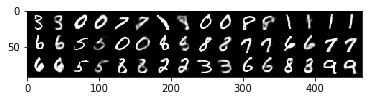

In [48]:
plot_reconstruction(model_G)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the plot_conditional_generation() function.

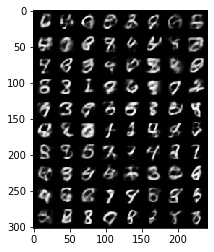

In [49]:
plot_conditional_generation(model_G, n=8)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable. We can track the normalized mutual information (see this method in scikit-learn) between the true labels and the labels predicted by our network (just by taking the category with maximal probability).

Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

This problem is explained in (Burgess et al., 2018) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to (Dupont, 2018), Section 3 Equation (7).

Implement this change in the training loop and plot the new NMI curve. For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [45]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [63]:
def train_G_modified_loss(model, data_loader,num_epochs, beta , C_z_fin, C_c_fin, verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            
            x_reconst, mu, log_var, q = model(x)
            _, _, q_encoded = model.encode(x)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            H_cat = -F.cross_entropy(q_encoded, labels)

            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
            # Backprop and optimize
            loss = reconst_loss + beta * torch.abs(H_cat - C_c_fin) + beta * torch.abs(kl_div - C_z_fin)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, H_cat.item()/batch_size))

In [64]:
# Hyper-parameters
num_epochs = 10
learning_rate = 1e-3
beta = 20
C_z_fin=200
C_c_fin=200

model_G = VAE_Gumbel(z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

train_G_modified_loss(model_G, data_loader, num_epochs=num_epochs, beta=beta, C_z_fin=C_z_fin, C_c_fin=C_c_fin)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch[1/10], Step [10/469], Reconst Loss: 360.9360, KL Div: 1.5333, Entropy: -0.0180
Epoch[1/10], Step [20/469], Reconst Loss: 253.8522, KL Div: 1.5651, Entropy: -0.0188
Epoch[1/10], Step [30/469], Reconst Loss: 220.7959, KL Div: 1.6180, Entropy: -0.0199
Epoch[1/10], Step [40/469], Reconst Loss: 213.9008, KL Div: 1.5251, Entropy: -0.0210
Epoch[1/10], Step [50/469], Reconst Loss: 212.1927, KL Div: 1.3889, Entropy: -0.0203
Epoch[1/10], Step [60/469], Reconst Loss: 200.0050, KL Div: 2.1804, Entropy: -0.0223
Epoch[1/10], Step [70/469], Reconst Loss: 202.5051, KL Div: 1.8704, Entropy: -0.0206
Epoch[1/10], Step [80/469], Reconst Loss: 203.7879, KL Div: 1.6883, Entropy: -0.0208
Epoch[1/10], Step [90/469], Reconst Loss: 210.2120, KL Div: 1.1875, Entropy: -0.0195
Epoch[1/10], Step [100/469], Reconst Loss: 193.3292, KL Div: 1.2589, Entropy: -0.0194
Epoch[1/10], Step [110/469], Reconst Loss: 202.8896, KL Div: 2.0428, Entropy: -0.0214
Epoch[1/10], Step [120/469], Reconst Loss: 201.9264, KL Div: 1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


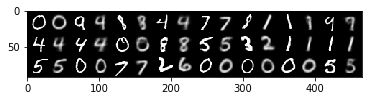

In [65]:
plot_reconstruction(model_G)

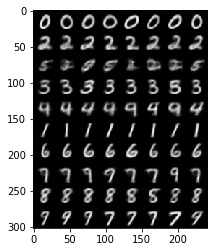

In [66]:
plot_conditional_generation(model_G, fix_number=None)

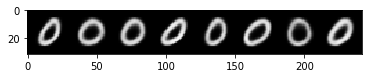

In [67]:
plot_conditional_generation(model_G, fix_number=0)